In [ ]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms  
import torchvision
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import pandas as pd
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

In [ ]:
base_dir = '/content/drive/MyDrive/Scenes training set'
splitfolders.ratio(base_dir , output="/content/drive/MyDrive/output", seed=1337, ratio=(.7, 0.3)) 

Copying files: 14034 files [06:06, 38.28 files/s]


In [ ]:
data_dir_Train = '/content/drive/MyDrive/output/train'
data_dir_Test = '/content/drive/MyDrive/output/val'
data_dir_pred = '/content/drive/MyDrive/testing/Scenes testing test'

train_dir = data_dir_Train 
valid_dir = data_dir_Test 
pred_files = [os.path.join(data_dir_pred, f) for f in os.listdir(data_dir_pred)]

outcomes = os.listdir(train_dir)
outcomes

['buildings', 'street', 'forest', 'mountain', 'sea', 'glacier']

Augmentation

In [ ]:
# convert data to a normalized torch.FloatTensor
transform = torchvision.transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(p=0.5), # randomly flip and rotate
    transforms.ColorJitter(0.3,0.4,0.4,0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
    ])

# Augmentation on test images not needed
transform_tests = torchvision.transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.255, 0.245, 0.235))
    ])

In [ ]:
train_data = torchvision.datasets.ImageFolder(root=train_dir,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=valid_dir,transform=transform_tests)


valid_size = 0.15
# Splot data into train and validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
train_loader = DataLoader(train_data,batch_size=50,sampler=train_sampler,num_workers=2)
valid_loader = DataLoader(train_data, batch_size =100, sampler=valid_sampler, num_workers=3)
test_loader= DataLoader(test_data,batch_size=32,shuffle=False,num_workers=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

device =  torch.device('cuda' if torch.cuda.is_available else 'cpu')

Using pretrained model.

In [ ]:
import torchvision
model = torchvision.models.wide_resnet50_2(pretrained=True)

for param in model.parameters():
    param.required_grad = False


num_ftrt = model.fc.in_features

model.fc = nn.Linear(num_ftrt,6)
model.to(device)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
# Specify loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6], gamma=0.06)

Train model

In [ ]:
# number of epochs for training set
epochs = 7

# track change in validation loss
valid_loss_min = np.Inf
val_loss = []
tn_loss = []
for epoch in range(1,epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Train the model
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):       
        # move tensor to gpu if cuda is available
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # clear the gradiant of all optimizer variable
        optimizer.zero_grad()
        # forward pass: compute pradictions by passing inputs
        output = model(data)
        # calculate batch loss
        loss = criterion(output, target)
        # backward pass: compute gradiant of the loss with respect to the parameters
        loss.backward()
        # update parameters by optimizing single step
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)

    # validate the model

    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensor to gpu
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        # forward pass: compute the validation predictions
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update the validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average loss
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    val_loss.append(valid_loss)
    tn_loss.append(train_loss)
    # update learning rate
    scheduler.step()
    # Print the train and validation loss statistic
    print('Epoch: {} \t Training Loss: {:.3f} \t Validation Loss: {:.3f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss decrease
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased {:.4f}--->{:.4f}  Saving model...".format(valid_loss_min, valid_loss))
        # save current model
        torch.save(model.state_dict(), 'model_state.pt')
        valid_loss_min = valid_loss
    print('Learning Rate ------------->{:.4f}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

Epoch: 1 	 Training Loss: 0.578 	 Validation Loss: 0.240
Validation loss decreased inf--->0.2396  Saving model...
Learning Rate ------------->0.0100
Epoch: 2 	 Training Loss: 0.240 	 Validation Loss: 0.190
Validation loss decreased 0.2396--->0.1897  Saving model...
Learning Rate ------------->0.0100
Epoch: 3 	 Training Loss: 0.171 	 Validation Loss: 0.176
Validation loss decreased 0.1897--->0.1757  Saving model...
Learning Rate ------------->0.0100
Epoch: 4 	 Training Loss: 0.131 	 Validation Loss: 0.178
Learning Rate ------------->0.0006
Epoch: 5 	 Training Loss: 0.097 	 Validation Loss: 0.166
Validation loss decreased 0.1757--->0.1663  Saving model...
Learning Rate ------------->0.0006
Epoch: 6 	 Training Loss: 0.096 	 Validation Loss: 0.168
Learning Rate ------------->0.0000
Epoch: 7 	 Training Loss: 0.092 	 Validation Loss: 0.173
Learning Rate ------------->0.0000


Load saved parameters

In [ ]:
# Load model state dict
model.load_state_dict(torch.load('model_state.pt'))
model.eval()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
correct_count, all_count = 0,0
for images, labels in test_loader:
    for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        img = images[i].view(1,3,150,150)
        with torch.no_grad():
            logps = model(img)
            
        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1
        
print("Number of images Tested=", all_count)
print("\n Model Accuracy=",(correct_count/all_count)*100)

Number of images Tested= 4214

 Model Accuracy= 93.37921214997627


Image Predictions

In [ ]:
def pred_class(img):
    # transform images
    img_tens = transform_tests(img)
    # change image format (3,150,150) to (1,3,150,150) by help of unsqueeze function
    # image needs to be in cuda before predition
    img_im = img_tens.unsqueeze(0).cuda() 
    uinput = Variable(img_im)
    uinput = uinput.to(device)
    out = model(uinput)
    # convert image to numpy format in cpu and snatching max prediction score class index
    index = out.data.cpu().numpy().argmax()    
    return index

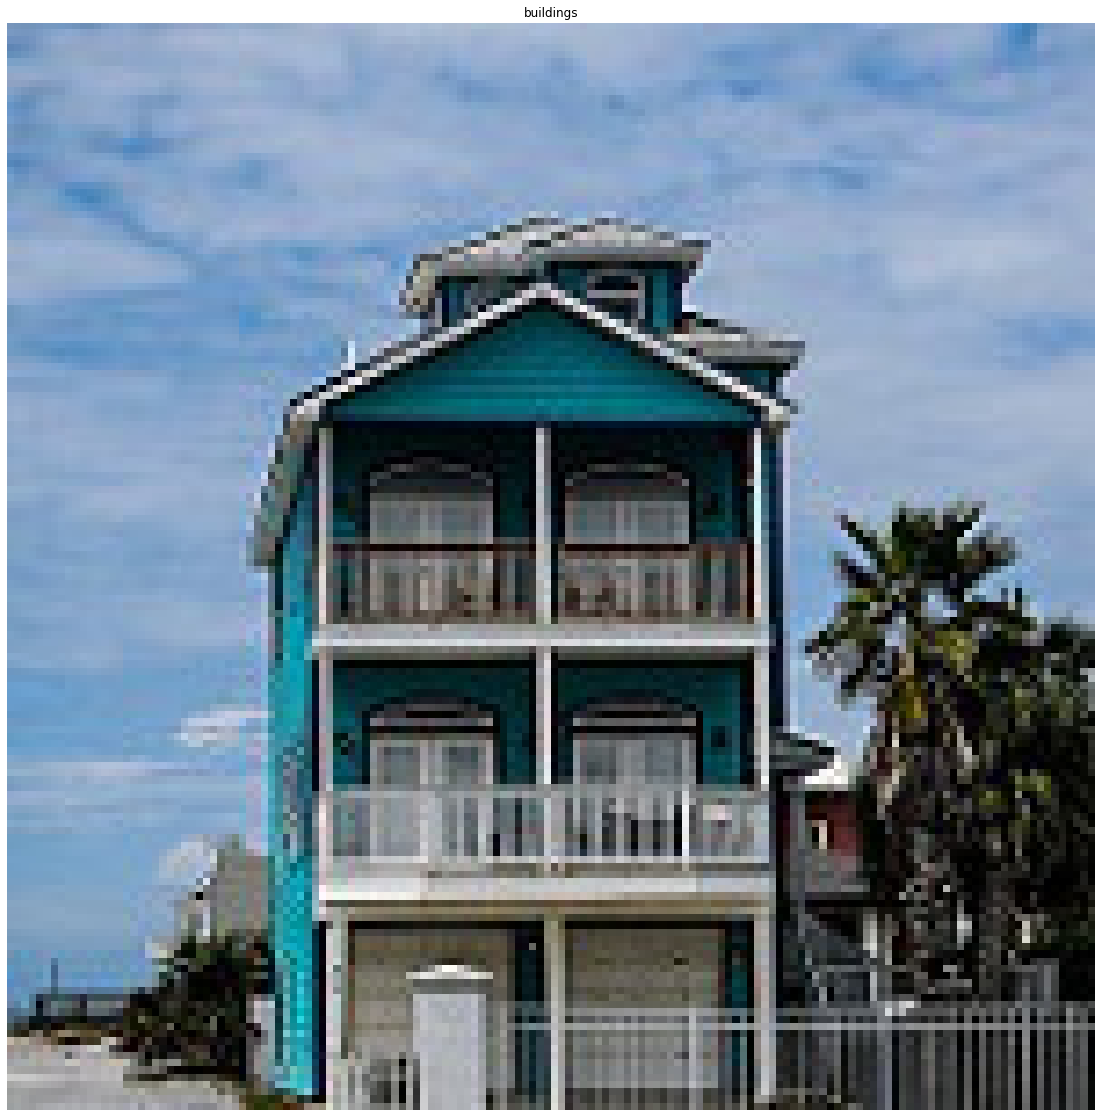

In [ ]:
# make class dictionary so i can grab class name by index(key)
classes = {k:v for k , v in enumerate(sorted(outcomes))}
model.eval()

predictions=[]
plt.figure(figsize=(20,20))
for i, images in enumerate(pred_files):
    # just want 25 images to print
    img = Image.open(images)
    index = pred_class(img)
    predictions.append(index)

    
  
    

In [ ]:
name_image=os.listdir(data_dir_pred)

In [ ]:
data={'Image':name_image,'Label':predictions}

In [ ]:
df = pd.DataFrame(data, columns =['Image','Label'])

In [ ]:
df.to_csv('/content/drive/MyDrive/submit.csv', index=False)